In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Activation,
    BatchNormalization, Conv2DTranspose, Concatenate
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers


2025-04-13 00:37:04.355173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-13 00:37:04.355259: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-13 00:37:04.357149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 00:37:04.500856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-13 00:37:05.899006: W tensorflow/compiler/

In [2]:
os.environ['CUDA-DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA-VISIBLE_DEVICE'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
!nvidia-smi

Sun Apr 13 00:37:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 3000                On  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8             11W /   50W |     138MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# import kagglehub

# path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

# print("Path to dataset files:", path)

path = "./1"

In [7]:
train_dir = path+'/tiff/train/'
mask_dir = path+'/tiff/train_labels/'
 
val_dir = path+'/tiff/val/'
v_mask_dir = path+'/tiff/val_labels/'

test_dir = path+'/tiff/test/'
t_mask_dir = path+'/tiff/test_labels/'

image_shape = (256,256)

In [8]:
def preprocess_mask_image2(image, class_num, color_limit):
  pic = np.array(image)
  img = np.zeros((pic.shape[0], pic.shape[1], 1))  
  np.place(img[ :, :, 0], pic[ :, :, 0] >= color_limit, 1)  
  return img

In [9]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [10]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [11]:
def train_generator(img_dir, label_dir, batch_size, input_size):
    list_images = os.listdir(label_dir)
    # shuffle(list_images) #Randomize the choice of batches
    ids_train_split = range(len(list_images))

    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = img_dir + list_images[id]+'f'
              mask_name = label_dir + list_images[id]
  
              img = cv2.imread(img_name) 
              img  = cv2.resize(img, image_shape, interpolation=cv2.INTER_AREA)
  
              mask = cv2.imread(mask_name)
              mask = cv2.resize(mask, image_shape, interpolation=cv2.INTER_AREA)
              mask = preprocess_mask_image2(mask, 2, 50)                
              
              x_batch += [img]
              y_batch += [mask]    

    
            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch) 

            yield x_batch, np.expand_dims(y_batch, -1)

In [12]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

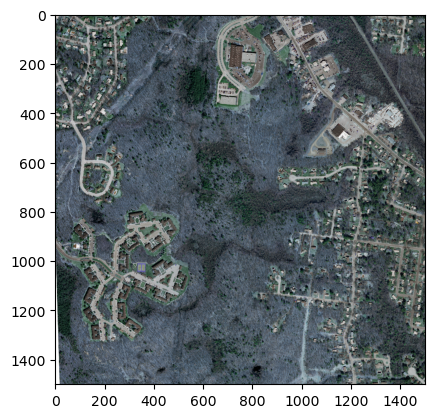

In [13]:
image = cv2.imread(path+"/tiff/val/24328810_15.tiff")

plt.imshow(image)

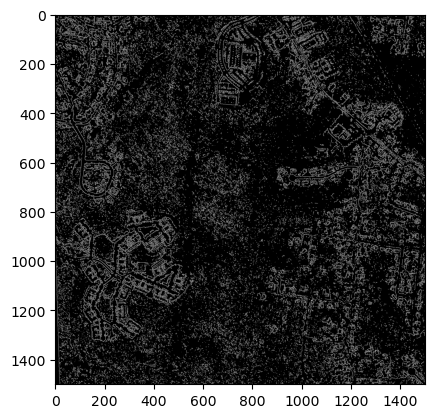

In [14]:
# Setting parameter values 
t_lower = 250  # Lower Threshold 
t_upper = 300  # Upper threshold 

# Applying the Canny Edge filter 
edge = cv2.Canny(image,t_lower,t_upper)

plt.imshow(edge,cmap='gray')

In [15]:
from tensorflow.keras.metrics import Precision, Recall, AUC   # Import for IOU calculation
precision = Precision(name='precision')
recall = Recall(name='recall')
iou = AUC(name='iou')
f1 = F1Score(name='f1')

accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy') 
import tensorflow as tf
import cv2

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=not apply_batchnorm))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

def canny_edge_detection(input_tensor):
    def apply_canny(image):
        image = tf.cast(image, tf.uint8)  # Ensure the input is in uint8 format
        edges = tf.numpy_function(cv2.Canny, [image,250,300], tf.uint8)
        edges = tf.expand_dims(edges, axis=-1)  # Add channel dimension
        return edges

    result = tf.map_fn(apply_canny, input_tensor, dtype=tf.uint8)
    
    # Set shape explicitly to retain TensorFlow compatibility
    result.set_shape(input_tensor.shape[:-1] + (1,))
    
    return result

def Net(num_classes=1, input_shape=(256,256, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Reduced Downsampling Stack
    down_stack = [
        downsample(32, 4, apply_batchnorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
    ]

    # Reduced Upsampling Stack
    up_stack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4),
        upsample(32, 4),
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(num_classes, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Canny edge detection branch
    edge_branch = tf.keras.layers.Lambda(canny_edge_detection)(inputs)
    edge_branch = tf.cast(edge_branch, tf.float32) / 255.0

    # Resize edge_branch to match dimensions
    edge_branch = tf.image.resize(edge_branch, (128,128))

    # Adjust channel depth
    edge_branch = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(edge_branch)

    # Combine main branch with edge branch
    x = tf.keras.layers.Concatenate()([x, edge_branch])

    x = last(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

# Instantiate the model
model = Net()
model.summary()


2025-04-13 00:53:41.274201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-13 00:53:41.577298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-13 00:53:41.577348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-13 00:53:41.582320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-13 00:53:41.582394: I tensorflow/compile

Instructions for updating:
Use fn_output_signature instead
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 32)         1568      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 64)           33024     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 128)          131584    ['sequential_1[0][0]']        
                                   

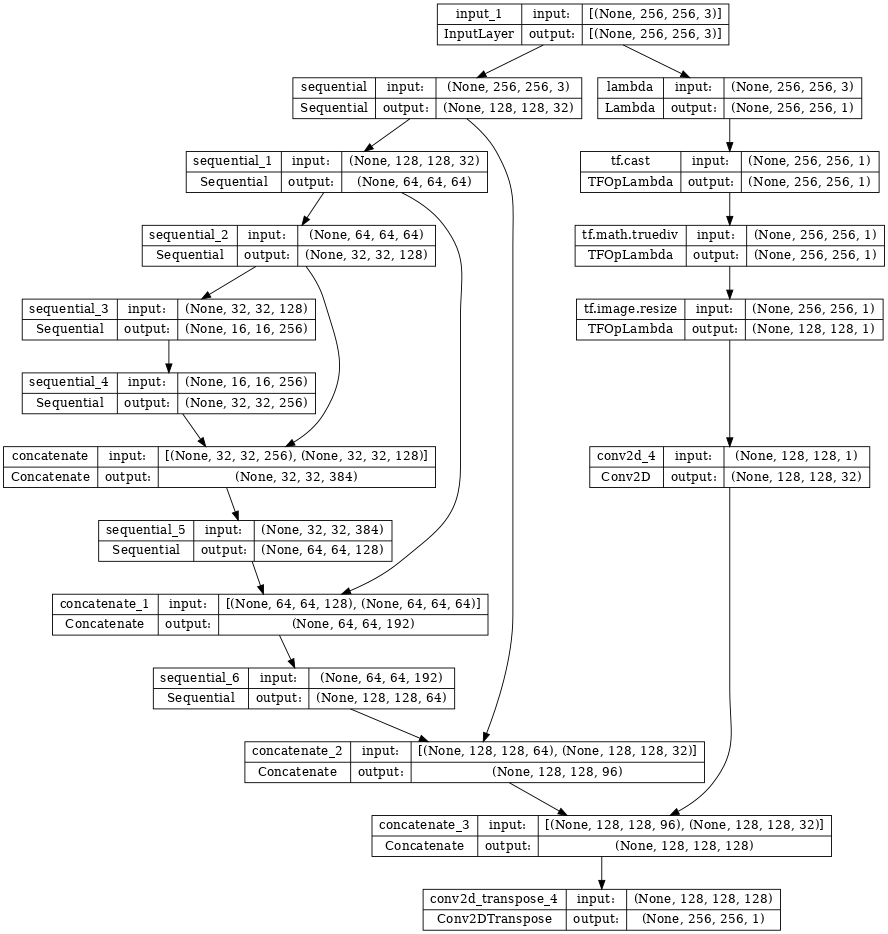

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [17]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=adam,
                  loss=dice_coef_loss,
                metrics=[precision, recall, iou, accuracy,f1])

In [18]:
# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=3,            # Number of epochs to wait before stopping
    restore_best_weights=True,  # Restore the best weights when stopped
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',       # Path to save the best model
    monitor='val_loss',    # Monitor validation loss
    save_best_only=True,   # Save the best model based on the metric
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.2,            # Factor by which the learning rate will be reduced
    patience=2,            # Number of epochs with no improvement before reducing LR
    verbose=1
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',      # Directory to save TensorBoard logs
    histogram_freq=1,      # Frequency of histogram computation
    write_graph=True,      # Write the computation graph
    write_images=True      # Write images to TensorBoard
)


batch_size = 2
history = model.fit_generator(train_generator(train_dir, mask_dir, batch_size, image_shape),                              
                              steps_per_epoch=554,
                              epochs=10,
                              verbose=1,
                              callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback],
                              validation_data=train_generator(val_dir, v_mask_dir, batch_size, image_shape),
                              validation_steps=1,
                              class_weight=None,
                              max_queue_size=10,
                              workers=1
                              )

/tmp/ipykernel_202548/625100160.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator(train_dir, mask_dir, batch_size, image_shape),
/home/avinash/miniconda3/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/10


2025-04-13 00:54:07.554314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-13 00:54:09.544133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-04-13 00:54:10.634610: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2025-04-13 00:54:11.683185: W tensorflow/tsl/framework/bfc_allocator

In [ ]:
model.save_weights('my_checkpoint')

In [ ]:
train_loss = history.history['loss']
train_recall = history.history['recall']
train_precision = history.history['precision']
train_iou = history.history['iou']

val_loss = history.history['val_loss']
val_recall = history.history['val_recall']
val_precision = history.history['val_precision']
val_iou = history.history['val_iou']

epochs = range(len(train_loss))  # Assuming loss is recorded for each epoch

# Plot loss curves
plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')  # Save the plot as an image

plt.figure()
plt.plot(epochs, train_recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.savefig('recall_curve.png')

plt.figure()
plt.plot(epochs, train_precision, label='Training Precision')
plt.plot(epochs, val_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig('precision_curve.png')

plt.figure()
plt.plot(epochs, train_iou, label='Training IOU')
plt.plot(epochs, val_iou, label='Validation IOU')
plt.title('Training and Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.grid(True)
plt.savefig('iou_curve.png')

plt.show() 

In [ ]:
import pandas as pd

# Extracting history from the model's training process
history_data = history.history

# Convert history data into a DataFrame
history_df = pd.DataFrame({
    'epoch': range(1, len(history_data['loss']) + 1),
    'loss': history_data['loss'],
    'precision': history_data['precision'],
    'recall': history_data['recall'],
    'iou': history_data['iou'],
    'accuracy': history_data['accuracy'],
    'f1': history_data['f1'],
    'val_loss': history_data['val_loss'],
    'val_precision': history_data['val_precision'],
    'val_recall': history_data['val_recall'],
    'val_iou': history_data['val_iou'],
    'val_accuracy': history_data['val_accuracy'],
    'val_f1': history_data['val_f1']
})

# Display the table
history_df.tail()

In [ ]:
def prepare_test_image(image):    
  x_batch = []   
  # img = cv2.imread(image_path)  
  img  = cv2.resize(image, image_shape, interpolation=cv2.INTER_AREA)
  x_batch += [img]           
  x_batch = np.array(x_batch) / 255.        

  return x_batch



In [ ]:
def binaryImage(image):
  x = image.shape[1]
  y = image.shape[2]
  imgs = np.zeros((x,y,3))
  for k in range(x):
    for n in range(y):
      if image[0,k,n]>0.5:
        imgs[k,n,0]=255
        imgs[k,n,1]=255
        imgs[k,n,2]=255
        # print(imgs[k,n])
      # else:
      #   imgs[k,n]=0
  return imgs 



def draw(orig_im, mask_im, recogn_im, out_im):  
  plt.figure(figsize=(20,17))
  plt.subplot(1,4,1)
  plt.title('Original')
  plt.imshow(orig_im)
  plt.subplot(1,4,2)
  plt.title('Mask Original')
  plt.imshow(mask_im)
  plt.subplot(1,4,3)
  plt.title('Recogn Roads')
  plt.imshow(recogn_im)
  plt.subplot(1,4,4)
  plt.title('Out Unet')
  plt.imshow(out_im)
  plt.axis('off')
  plt.show()




def recogn_test_image():
  test_images = os.listdir(t_mask_dir)

  for test in test_images:
    im_test = cv2.imread(test_dir+test+'f')
    im_mask = cv2.imread(t_mask_dir+test)
    out_test = model.predict(prepare_test_image(im_test), verbose=0)
    img_r = binaryImage(out_test)
    draw(im_test, im_mask, img_r, out_test[0,:, :, 0]*255) 

  


In [ ]:
recogn_test_image()